In [ ]:
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio
!pip install -q bitsandbytes datasets accelerate loralib
!pip install transformers==4.45.2
!pip install peft
!pip install matplotlib
!pip install tensorboard

In [10]:
# -------------------Set model properties-----------------------------------
model_name_or_path = "openai/whisper-small"
language = "bengali"
task = "transcribe"

In [6]:
#---------------------------Load Dataset--------------------------------------
from datasets import load_dataset, DatasetDict

# Load the full dataset
full_train = load_dataset("imonghose/bengali-asr-data", split="train")
full_test = load_dataset("imonghose/bengali-asr-data", split="test")



# Get dataset sizes
train_size = len(full_train)
test_size = len(full_test)

# Compute the original train-test ratio
original_ratio = test_size / train_size

# Compute the new test size corresponding to 60% train size
new_train_size = int(0.05 * train_size)
new_test_size = int(0.2 * test_size)

train_sample = full_train.shuffle(seed=42).select(range(new_train_size))
test_sample = full_test.shuffle(seed=42).select(range(new_test_size))

# Create a new dataset dictionary
bangla_dataset = DatasetDict({
    "train": train_sample,
    "test": test_sample
})


Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [7]:
#-----------Check dataset shape----------
bangla_dataset.shape

{'train': (7978, 3), 'test': (2042, 3)}

In [8]:
#-----------Check dataset structure----------
bangla_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'length'],
        num_rows: 7978
    })
    test: Dataset({
        features: ['audio', 'sentence', 'length'],
        num_rows: 2042
    })
})

In [11]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path,language=language,task=task)

In [12]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path,language=language,task=task)

In [8]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)

In [9]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [13]:
#-------------------Check sampling rate before downsampling-----------------
print(bangla_dataset["train"][16])

{'audio': {'path': None, 'array': array([-0.00280762, -0.00262451, -0.00244141, ..., -0.00317383,
        0.00238037,  0.00650024]), 'sampling_rate': 16000}, 'sentence': 'পদ্মা সেতু প্রকল্প পরিচালক', 'length': 2.5}


In [14]:
#--------------------Downsample to 16 KHz--------------------------
from datasets import Audio

bangla_dataset = bangla_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [15]:
#-------------------Check sampling rate after downsampling-----------------
print(bangla_dataset["train"][0])

{'audio': {'path': None, 'array': array([ 0.00189209,  0.0015564 ,  0.00189209, ...,  0.00039673,
        0.00033569, -0.00079346]), 'sampling_rate': 16000}, 'sentence': 'আবদুর রহমান বয়াতি', 'length': 3.2}


In [16]:
#------------------Custom preprocessing function for dataset-----------------------------
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch


In [17]:
#-------------------------Execute preprocessing---------------------------
bangla_dataset = bangla_dataset.map(prepare_dataset, remove_columns=bangla_dataset.column_names["train"], num_proc=1)


In [18]:
#--------------check dataset structure after preprocessing------------
bangla_dataset["test"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 2042
})

In [19]:
#--------------check dataset structure after preprocessing------------
bangla_dataset["train"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 7978
})

In [20]:
#-------------------Check first sentence by decoding-----------------------
first_label_ids = bangla_dataset["train"][0]["labels"]  # Get the first label (token IDs)
first_sentence = tokenizer.decode(first_label_ids)  # Decode to text

print(first_sentence)


<|startoftranscript|><|bn|><|transcribe|><|notimestamps|>আবদুর রহমান বয়াতি<|endoftext|>


In [ ]:
# -----------------------------Visualization of sentence token sizes vs frequency------------------------
import matplotlib.pyplot as plt

list_of_transcription_lengths = []

# Extract labels from dataset and compute their lengths
for data in bangla_dataset["train"]:
    list_of_transcription_lengths.append(len(data["labels"]))

# Plot the histogram
plt.hist(list_of_transcription_lengths, bins=50)  # Adjust bins for better visualization
plt.xlabel("Sentence Length (Number of Tokens)")
plt.ylabel("Number of Transcripts")
plt.title("Distribution of Transcription Lengths")
plt.show()


In [19]:
#------------------------------Check true vs prediction on few sentences before fine-tuning------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-------7------
True : চলতে পারিনা 
Pred :  चोलते परिना

 
-------8------
True : নিজের স্বজনের জন্য 
Pred :  निजर साजने जन्नो

 
-------9------
True : সে যুদ্ধকেই 
Pred :  शेजुद्द के इए

 


In [20]:
#-------------------------------------Define Data Collator to introduce padding-------------------------------
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [21]:
#----------------------------Load Data Collator-----------------------------
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [22]:
#------------------------Define evaluation metric wer------------------------
import evaluate
wer = evaluate.load("wer")

In [62]:
#===================================Custom Evaluation Function for WER Metric with Periodic Plotting===================================
import torch
import pickle
from tqdm import tqdm
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

wer = evaluate.load("wer")
SAVE_PATH = "evaluation_progress1.pkl"

def save_progress(progress):
    with open(SAVE_PATH, "wb") as f:
        pickle.dump(progress, f)

def load_progress():
    try:
        with open(SAVE_PATH, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {"predictions": [], "references": [], "processed_batches": 0, "wer_history": [], "batch_history": []}

def plot_wer(batch_history, wer_history):
    clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.plot(batch_history, wer_history, marker='o', label='WER (%)')
    plt.xlabel('Batches Processed')
    plt.ylabel('WER')
    plt.title('Running WER Evaluation')
    plt.grid(True)
    plt.legend()
    # Set ticks at intervals of 25 starting from 0 to max batch
    max_batch = max(batch_history) if batch_history else 0
    plt.xticks(np.arange(0, max_batch + 1, 25))
    display(plt.gcf())
    plt.close()

def evaluation(model, resume=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    test_dataset = bangla_dataset["test"]
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        collate_fn=data_collator
    )

    model.eval()

    # Load previous progress if resuming
    progress = load_progress() if resume else {"predictions": [], "references": [], "processed_batches": 0, "wer_history": [], "batch_history": []}
    predictions, references = progress["predictions"], progress["references"]
    start_batch = progress["processed_batches"]
    wer_history = progress.get("wer_history", [])
    batch_history = progress.get("batch_history", [])

    for batch_idx, batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
        if batch_idx < start_batch:
            continue  # Skip already processed batches

        input_features = batch["input_features"].to(device)
        labels = batch["labels"]

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features, language='bengali', task='transcribe')

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)

        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

        is_final = (batch_idx == len(test_dataloader) - 1)
        if (batch_idx + 1) % 25 == 0 or is_final:
            current_wer = wer.compute(predictions=predictions, references=references) * 100
            wer_history.append(current_wer)
            batch_history.append(batch_idx + 1)
            plot_wer(batch_history, wer_history)
            save_progress({
                "predictions": predictions,
                "references": references,
                "processed_batches": batch_idx + 1,
                "wer_history": wer_history,
                "batch_history": batch_history
            })

    return wer_history[-1] if wer_history else None


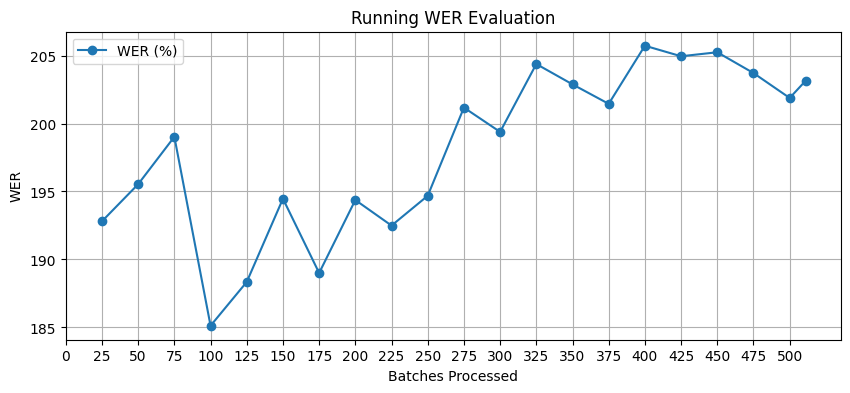

100%|██████████| 511/511 [1:10:11<00:00,  8.24s/it]


203.14186920072638

In [23]:
# Evaluate WER before the training
torch.cuda.empty_cache()
# evaluation(model)
evaluation(model,resume=True)

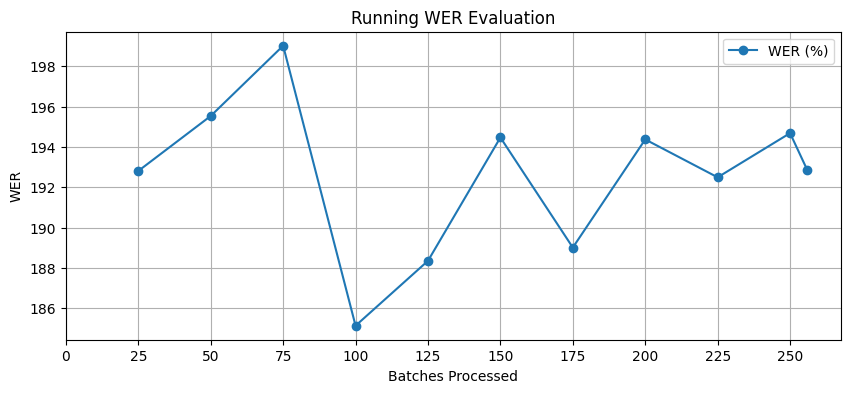

100%|██████████| 256/256 [1:06:23<00:00, 15.56s/it]


192.83608932407455

In [24]:
# Evaluate WER before the training
torch.cuda.empty_cache()
# evaluation(model)
# evaluation(model)
evaluation(model, resume=True)

In [46]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

In [51]:
#-----------------------------------Load and add LoRA model to base model-----------------------------------
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

config = LoraConfig(r=32, lora_alpha=64, target_modules=["k_proj", "v_proj", "q_proj", "out_proj"], lora_dropout=0.05, bias="none")

model = get_peft_model(model, config)
model.print_trainable_parameters()
for n,p in model.named_parameters():
    print(n,p.requires_grad)

trainable params: 7,077,888 || all params: 248,812,800 || trainable%: 2.8447
base_model.model.base_model.model.model.encoder.conv1.weight False
base_model.model.base_model.model.model.encoder.conv1.bias False
base_model.model.base_model.model.model.encoder.conv2.weight False
base_model.model.base_model.model.model.encoder.conv2.bias False
base_model.model.base_model.model.model.encoder.embed_positions.weight False
base_model.model.base_model.model.model.encoder.layers.0.self_attn.k_proj.base_layer.weight False
base_model.model.base_model.model.model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight True
base_model.model.base_model.model.model.encoder.layers.0.self_attn.k_proj.lora_B.default.weight True
base_model.model.base_model.model.model.encoder.layers.0.self_attn.v_proj.base_layer.weight False
base_model.model.base_model.model.model.encoder.layers.0.self_attn.v_proj.base_layer.bias False
base_model.model.base_model.model.model.encoder.layers.0.self_attn.v_proj.lora_A.default

In [57]:
#----------------------------Create Training Arguments------------------------------
from transformers import Seq2SeqTrainingArguments,EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir="lora-checkpoints",
    per_device_train_batch_size=2,  # Reduced from 8 to 2
    per_device_eval_batch_size=2,  # Reduced from 8 to 2
    gradient_accumulation_steps=2,  # Helps with small batch size
    # learning_rate=2e-5, (High)
    learning_rate=1e-5,  #(Medium)
    # learning_rate=5e-6,  #(Low)
    warmup_steps=50,
    num_train_epochs=2,
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    eval_steps=142,
    # save_strategy="epoch",
    save_strategy="steps",
    save_steps=284, 
    save_total_limit=2,
    load_best_model_at_end=True,  # Disabling to save memory
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,  # Mixed precision enabled
    generation_max_length=128,
    logging_steps=25,
    remove_unused_columns=False,
    label_names=["labels"],

    # Add AdamW optimizer and related arguments
    optim="adamw_torch",  # AdamW optimizer from PyTorch
    weight_decay=0.01,  # Regularization to prevent overfitting
    adam_epsilon=1e-8,   # Epsilon for numerical stability
    max_grad_norm=1.0,   # Gradient clipping
    # TensorBoard logging
    logging_dir="./lora-tensorboard",  # Directory for TensorBoard logs
    report_to="tensorboard",  # Enables logging to TensorBoard
)

In [58]:
#--------------------------------Create Trainer--------------------------------------
from transformers import Seq2SeqTrainer

# Use only 10% of the test dataset for evaluation
eval_sample = bangla_dataset["test"].shuffle(seed=42).select(range(int(0.5 * len(bangla_dataset["test"]))))

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=bangla_dataset["train"],
    eval_dataset=bangla_dataset["test"],
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
model.gradient_checkpointing_enable() #Gradient checkpointing helps save memory by recomputing activations during the backward pass.

In [71]:
#-------------------Code for Cleaning GPU Cache--------------------------
# import torch
# import gc

# gc.collect()  # Clean up RAM
# torch.cuda.empty_cache()  # Free GPU memory

# print("✅ GPU memory forcibly cleared!")


✅ GPU memory forcibly cleared!


In [53]:
#----------------Code to check stored huggingface dataset files in cache---------------
# !ls -lh ~/.cache/huggingface/datasets

total 4.0K
drwxr-xr-x 3 root root 4.0K Mar 17 21:31 imonghose___bengali-asr-data
-rw-r--r-- 1 root root    0 Mar 17 21:36 _root_.cache_huggingface_datasets_imonghose___bengali-asr-data_default_0.0.0_3a297ddede51b3012d3a6eb39e9dbea12b8ccc40.lock


In [23]:
#--------------------Login to Huggingface (if required)-----------------------------------
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#-------------------Check if a checkpoint file exists-----------------------
# ls -lh checkpoints/checkpoint-1197
# checkpoint_path = get_last_checkpoint("checkpoints")
# checkpoint_path

In [55]:
torch.cuda.empty_cache()

In [59]:
#-------------------------------Start Training with support for checkpointing--------------------------
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, Trainer
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model
from transformers.trainer_utils import get_last_checkpoint
from transformers import WhisperForConditionalGeneration

config = LoraConfig(r=32, lora_alpha=64, target_modules=["k_proj", "v_proj", "q_proj", "out_proj"], lora_dropout=0.05, bias="none")

checkpoint_path = get_last_checkpoint("lora-checkpoints")

if checkpoint_path is not None:
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    peft_base_model = get_peft_model(WhisperForConditionalGeneration.from_pretrained("openai/whisper-small"), config)
    loaded_model_from_checkpoint = PeftModel.from_pretrained(peft_base_model, checkpoint_path).to('cuda')
    model = loaded_model_from_checkpoint
    trainer.model = model  # Load the trained model into the trainer
    trainer.train(resume_from_checkpoint=checkpoint_path)  # Resume training
else:
    print("No checkpoint found, starting from scratch.")
    torch.cuda.empty_cache()
    trainer.train()  # Start training from scratch

No checkpoint found, starting from scratch.


  1%|          | 25/3988 [00:14<38:29,  1.72it/s] 

{'loss': 2.7792, 'grad_norm': 2.5160531997680664, 'learning_rate': 5e-06, 'epoch': 0.01}


  1%|▏         | 50/3988 [00:29<44:02,  1.49it/s]

{'loss': 2.5857, 'grad_norm': 2.687100648880005, 'learning_rate': 1e-05, 'epoch': 0.03}


  2%|▏         | 75/3988 [00:44<37:25,  1.74it/s]

{'loss': 2.4107, 'grad_norm': 2.040699005126953, 'learning_rate': 9.936515997968513e-06, 'epoch': 0.04}


  3%|▎         | 100/3988 [00:59<38:46,  1.67it/s]

{'loss': 2.1166, 'grad_norm': 2.535463571548462, 'learning_rate': 9.873031995937025e-06, 'epoch': 0.05}


  3%|▎         | 125/3988 [01:13<38:08,  1.69it/s]

{'loss': 1.9554, 'grad_norm': 2.771571397781372, 'learning_rate': 9.809547993905536e-06, 'epoch': 0.06}


  4%|▎         | 142/3988 [05:18<37:48,  1.70it/s] 

{'eval_loss': 1.6727900505065918, 'eval_runtime': 233.9671, 'eval_samples_per_second': 8.728, 'eval_steps_per_second': 4.364, 'epoch': 0.07}


  4%|▍         | 150/3988 [05:23<6:50:48,  6.42s/it] 

{'loss': 1.8255, 'grad_norm': 2.9114925861358643, 'learning_rate': 9.746063991874048e-06, 'epoch': 0.08}


  4%|▍         | 175/3988 [05:38<40:39,  1.56it/s]  

{'loss': 1.7566, 'grad_norm': 3.304548740386963, 'learning_rate': 9.68257998984256e-06, 'epoch': 0.09}


  5%|▌         | 200/3988 [05:54<39:02,  1.62it/s]

{'loss': 1.7479, 'grad_norm': 2.957446813583374, 'learning_rate': 9.619095987811072e-06, 'epoch': 0.1}


  6%|▌         | 225/3988 [06:10<38:18,  1.64it/s]

{'loss': 1.6825, 'grad_norm': 3.3711085319519043, 'learning_rate': 9.555611985779586e-06, 'epoch': 0.11}


  6%|▋         | 250/3988 [06:25<37:49,  1.65it/s]

{'loss': 1.6285, 'grad_norm': 3.394692897796631, 'learning_rate': 9.494667343829356e-06, 'epoch': 0.13}


  7%|▋         | 275/3988 [06:40<37:37,  1.65it/s]

{'loss': 1.5593, 'grad_norm': 5.267289638519287, 'learning_rate': 9.431183341797868e-06, 'epoch': 0.14}


  7%|▋         | 284/3988 [10:31<37:56,  1.63it/s] 

{'eval_loss': 1.5553754568099976, 'eval_runtime': 225.9193, 'eval_samples_per_second': 9.039, 'eval_steps_per_second': 4.519, 'epoch': 0.14}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
  8%|▊         | 300/3988 [10:41<56:42,  1.08it/s]   

{'loss': 1.5529, 'grad_norm': 3.8212549686431885, 'learning_rate': 9.36769933976638e-06, 'epoch': 0.15}


  8%|▊         | 325/3988 [10:57<36:34,  1.67it/s]

{'loss': 1.5729, 'grad_norm': 4.073215484619141, 'learning_rate': 9.304215337734892e-06, 'epoch': 0.16}


  9%|▉         | 350/3988 [11:12<36:12,  1.67it/s]

{'loss': 1.5349, 'grad_norm': 5.4354119300842285, 'learning_rate': 9.240731335703403e-06, 'epoch': 0.18}


  9%|▉         | 375/3988 [11:27<38:05,  1.58it/s]

{'loss': 1.4945, 'grad_norm': 3.460000991821289, 'learning_rate': 9.177247333671915e-06, 'epoch': 0.19}


 10%|█         | 400/3988 [11:43<37:54,  1.58it/s]

{'loss': 1.4538, 'grad_norm': 4.748506546020508, 'learning_rate': 9.113763331640427e-06, 'epoch': 0.2}


 11%|█         | 425/3988 [11:59<37:29,  1.58it/s]

{'loss': 1.4335, 'grad_norm': 5.78009557723999, 'learning_rate': 9.050279329608939e-06, 'epoch': 0.21}


 11%|█         | 426/3988 [15:43<38:08,  1.56it/s] 

{'eval_loss': 1.465135097503662, 'eval_runtime': 223.5521, 'eval_samples_per_second': 9.134, 'eval_steps_per_second': 4.567, 'epoch': 0.21}


 11%|█▏        | 450/3988 [15:58<35:45,  1.65it/s]   

{'loss': 1.4055, 'grad_norm': 4.638736248016357, 'learning_rate': 8.986795327577451e-06, 'epoch': 0.23}


 12%|█▏        | 475/3988 [16:13<34:39,  1.69it/s]

{'loss': 1.4056, 'grad_norm': 4.952413558959961, 'learning_rate': 8.923311325545963e-06, 'epoch': 0.24}


 13%|█▎        | 500/3988 [16:28<35:14,  1.65it/s]

{'loss': 1.3946, 'grad_norm': 6.356468677520752, 'learning_rate': 8.859827323514475e-06, 'epoch': 0.25}


 13%|█▎        | 525/3988 [16:43<34:24,  1.68it/s]

{'loss': 1.3479, 'grad_norm': 5.404243469238281, 'learning_rate': 8.796343321482988e-06, 'epoch': 0.26}


 14%|█▍        | 550/3988 [16:58<34:05,  1.68it/s]

{'loss': 1.3515, 'grad_norm': 4.3510661125183105, 'learning_rate': 8.732859319451498e-06, 'epoch': 0.28}


 14%|█▍        | 568/3988 [20:53<34:02,  1.67it/s] 

{'eval_loss': 1.3827606439590454, 'eval_runtime': 224.0019, 'eval_samples_per_second': 9.116, 'eval_steps_per_second': 4.558, 'epoch': 0.28}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 14%|█▍        | 575/3988 [20:57<8:04:52,  8.52s/it] 

{'loss': 1.3341, 'grad_norm': 4.163790702819824, 'learning_rate': 8.669375317420012e-06, 'epoch': 0.29}


 15%|█▌        | 600/3988 [21:12<33:56,  1.66it/s]  

{'loss': 1.3062, 'grad_norm': 4.582421779632568, 'learning_rate': 8.608430675469782e-06, 'epoch': 0.3}


 16%|█▌        | 625/3988 [21:28<35:32,  1.58it/s]

{'loss': 1.2731, 'grad_norm': 5.437370300292969, 'learning_rate': 8.544946673438294e-06, 'epoch': 0.31}


 16%|█▋        | 650/3988 [21:43<35:20,  1.57it/s]

{'loss': 1.2535, 'grad_norm': 4.450806140899658, 'learning_rate': 8.481462671406806e-06, 'epoch': 0.33}


 17%|█▋        | 675/3988 [21:59<32:51,  1.68it/s]

{'loss': 1.2219, 'grad_norm': 6.165369510650635, 'learning_rate': 8.417978669375318e-06, 'epoch': 0.34}


 18%|█▊        | 700/3988 [22:14<33:30,  1.64it/s]

{'loss': 1.2783, 'grad_norm': 6.573722839355469, 'learning_rate': 8.35449466734383e-06, 'epoch': 0.35}


 18%|█▊        | 710/3988 [26:08<32:54,  1.66it/s] 

{'eval_loss': 1.3193622827529907, 'eval_runtime': 227.9512, 'eval_samples_per_second': 8.958, 'eval_steps_per_second': 4.479, 'epoch': 0.36}


 18%|█▊        | 725/3988 [26:17<58:29,  1.08s/it]   

{'loss': 1.215, 'grad_norm': 6.986652374267578, 'learning_rate': 8.291010665312342e-06, 'epoch': 0.36}


 19%|█▉        | 750/3988 [26:32<32:12,  1.68it/s]

{'loss': 1.2313, 'grad_norm': 6.78316593170166, 'learning_rate': 8.227526663280854e-06, 'epoch': 0.38}


 19%|█▉        | 775/3988 [26:47<31:48,  1.68it/s]

{'loss': 1.1885, 'grad_norm': 5.533499717712402, 'learning_rate': 8.164042661249365e-06, 'epoch': 0.39}


 20%|██        | 800/3988 [27:02<31:29,  1.69it/s]

{'loss': 1.2221, 'grad_norm': 6.499080657958984, 'learning_rate': 8.100558659217877e-06, 'epoch': 0.4}


 21%|██        | 825/3988 [27:17<31:43,  1.66it/s]

{'loss': 1.2316, 'grad_norm': 6.194104194641113, 'learning_rate': 8.03707465718639e-06, 'epoch': 0.41}


 21%|██▏       | 850/3988 [27:33<33:43,  1.55it/s]

{'loss': 1.235, 'grad_norm': 4.858119487762451, 'learning_rate': 7.973590655154901e-06, 'epoch': 0.43}


 21%|██▏       | 852/3988 [31:22<33:03,  1.58it/s] 

{'eval_loss': 1.252810001373291, 'eval_runtime': 227.6486, 'eval_samples_per_second': 8.97, 'eval_steps_per_second': 4.485, 'epoch': 0.43}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 22%|██▏       | 875/3988 [31:36<32:26,  1.60it/s]   

{'loss': 1.2216, 'grad_norm': 6.217723846435547, 'learning_rate': 7.910106653123415e-06, 'epoch': 0.44}


 23%|██▎       | 900/3988 [31:51<30:49,  1.67it/s]

{'loss': 1.1125, 'grad_norm': 4.770164489746094, 'learning_rate': 7.846622651091925e-06, 'epoch': 0.45}


 23%|██▎       | 925/3988 [32:06<30:16,  1.69it/s]

{'loss': 1.159, 'grad_norm': 7.063056468963623, 'learning_rate': 7.783138649060438e-06, 'epoch': 0.46}


 24%|██▍       | 950/3988 [32:21<30:51,  1.64it/s]

{'loss': 1.144, 'grad_norm': 6.5507941246032715, 'learning_rate': 7.719654647028949e-06, 'epoch': 0.48}


 24%|██▍       | 975/3988 [32:36<30:20,  1.66it/s]

{'loss': 1.1087, 'grad_norm': 5.890785217285156, 'learning_rate': 7.656170644997462e-06, 'epoch': 0.49}


 25%|██▍       | 994/3988 [36:32<29:50,  1.67it/s] 

{'eval_loss': 1.2191728353500366, 'eval_runtime': 224.5104, 'eval_samples_per_second': 9.095, 'eval_steps_per_second': 4.548, 'epoch': 0.5}


 25%|██▌       | 1000/3988 [36:36<9:54:01, 11.93s/it]

{'loss': 1.147, 'grad_norm': 6.098300457000732, 'learning_rate': 7.592686642965973e-06, 'epoch': 0.5}


 26%|██▌       | 1025/3988 [36:51<29:39,  1.66it/s]  

{'loss': 1.0893, 'grad_norm': 8.403385162353516, 'learning_rate': 7.529202640934485e-06, 'epoch': 0.51}


 26%|██▋       | 1050/3988 [37:06<29:19,  1.67it/s]

{'loss': 1.1106, 'grad_norm': 7.8863348960876465, 'learning_rate': 7.465718638902997e-06, 'epoch': 0.53}


 27%|██▋       | 1075/3988 [37:21<29:46,  1.63it/s]

{'loss': 1.0762, 'grad_norm': 6.451296806335449, 'learning_rate': 7.4022346368715096e-06, 'epoch': 0.54}


 28%|██▊       | 1100/3988 [37:36<29:20,  1.64it/s]

{'loss': 1.1138, 'grad_norm': 8.626753807067871, 'learning_rate': 7.338750634840021e-06, 'epoch': 0.55}


 28%|██▊       | 1125/3988 [37:52<29:14,  1.63it/s]

{'loss': 1.0786, 'grad_norm': 11.375869750976562, 'learning_rate': 7.275266632808533e-06, 'epoch': 0.56}


 28%|██▊       | 1136/3988 [41:43<28:52,  1.65it/s]

{'eval_loss': 1.1835683584213257, 'eval_runtime': 224.6951, 'eval_samples_per_second': 9.088, 'eval_steps_per_second': 4.544, 'epoch': 0.57}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 29%|██▉       | 1150/3988 [41:52<59:34,  1.26s/it]   

{'loss': 1.0948, 'grad_norm': 6.825331211090088, 'learning_rate': 7.211782630777044e-06, 'epoch': 0.58}


 29%|██▉       | 1175/3988 [42:07<28:19,  1.66it/s]

{'loss': 1.0383, 'grad_norm': 5.664462089538574, 'learning_rate': 7.148298628745557e-06, 'epoch': 0.59}


 30%|███       | 1200/3988 [42:22<27:59,  1.66it/s]

{'loss': 1.1076, 'grad_norm': 5.76554536819458, 'learning_rate': 7.084814626714068e-06, 'epoch': 0.6}


 31%|███       | 1225/3988 [42:37<27:25,  1.68it/s]

{'loss': 1.0484, 'grad_norm': 7.921971797943115, 'learning_rate': 7.021330624682581e-06, 'epoch': 0.61}


 31%|███▏      | 1250/3988 [42:52<27:27,  1.66it/s]

{'loss': 1.0617, 'grad_norm': 5.980660438537598, 'learning_rate': 6.957846622651092e-06, 'epoch': 0.63}


 32%|███▏      | 1275/3988 [43:07<27:40,  1.63it/s]

{'loss': 1.0274, 'grad_norm': 7.652544021606445, 'learning_rate': 6.8943626206196045e-06, 'epoch': 0.64}


 32%|███▏      | 1278/3988 [46:57<27:09,  1.66it/s]

{'eval_loss': 1.1395037174224854, 'eval_runtime': 227.8199, 'eval_samples_per_second': 8.963, 'eval_steps_per_second': 4.482, 'epoch': 0.64}


 33%|███▎      | 1300/3988 [47:10<28:47,  1.56it/s]   

{'loss': 1.0217, 'grad_norm': 6.010395526885986, 'learning_rate': 6.8308786185881156e-06, 'epoch': 0.65}


 33%|███▎      | 1325/3988 [47:26<28:42,  1.55it/s]

{'loss': 0.985, 'grad_norm': 7.897751808166504, 'learning_rate': 6.767394616556628e-06, 'epoch': 0.66}


 34%|███▍      | 1350/3988 [47:42<28:13,  1.56it/s]

{'loss': 1.0304, 'grad_norm': 6.6576409339904785, 'learning_rate': 6.70391061452514e-06, 'epoch': 0.68}


 34%|███▍      | 1375/3988 [47:58<26:21,  1.65it/s]

{'loss': 0.9734, 'grad_norm': 6.509515285491943, 'learning_rate': 6.640426612493652e-06, 'epoch': 0.69}


 35%|███▌      | 1400/3988 [48:13<26:04,  1.65it/s]

{'loss': 1.0022, 'grad_norm': 5.380497455596924, 'learning_rate': 6.576942610462164e-06, 'epoch': 0.7}


 36%|███▌      | 1420/3988 [52:15<25:53,  1.65it/s]

{'eval_loss': 1.1106626987457275, 'eval_runtime': 229.8814, 'eval_samples_per_second': 8.883, 'eval_steps_per_second': 4.441, 'epoch': 0.71}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 36%|███▌      | 1425/3988 [52:18<12:13:34, 17.17s/it]

{'loss': 1.0538, 'grad_norm': 6.470683574676514, 'learning_rate': 6.513458608430676e-06, 'epoch': 0.71}


 36%|███▋      | 1450/3988 [52:33<25:53,  1.63it/s]   

{'loss': 1.0135, 'grad_norm': 7.746857166290283, 'learning_rate': 6.449974606399188e-06, 'epoch': 0.73}


 37%|███▋      | 1475/3988 [52:49<25:18,  1.66it/s]

{'loss': 1.0237, 'grad_norm': 6.815307140350342, 'learning_rate': 6.3864906043677e-06, 'epoch': 0.74}


 38%|███▊      | 1500/3988 [53:04<25:11,  1.65it/s]

{'loss': 1.0011, 'grad_norm': 14.105231285095215, 'learning_rate': 6.323006602336211e-06, 'epoch': 0.75}


 38%|███▊      | 1525/3988 [53:19<24:43,  1.66it/s]

{'loss': 0.9795, 'grad_norm': 7.543400764465332, 'learning_rate': 6.259522600304724e-06, 'epoch': 0.76}


 39%|███▉      | 1550/3988 [53:35<25:34,  1.59it/s]

{'loss': 0.9747, 'grad_norm': 6.589664936065674, 'learning_rate': 6.196038598273235e-06, 'epoch': 0.78}


 39%|███▉      | 1562/3988 [57:31<27:51,  1.45it/s]

{'eval_loss': 1.0882312059402466, 'eval_runtime': 227.6828, 'eval_samples_per_second': 8.969, 'eval_steps_per_second': 4.484, 'epoch': 0.78}


 39%|███▉      | 1575/3988 [57:38<1:02:23,  1.55s/it] 

{'loss': 1.0058, 'grad_norm': 8.625055313110352, 'learning_rate': 6.132554596241748e-06, 'epoch': 0.79}


 40%|████      | 1600/3988 [57:53<23:58,  1.66it/s]  

{'loss': 0.9651, 'grad_norm': 7.0204620361328125, 'learning_rate': 6.069070594210259e-06, 'epoch': 0.8}


 41%|████      | 1625/3988 [58:09<24:14,  1.62it/s]

{'loss': 0.9575, 'grad_norm': 6.4943342208862305, 'learning_rate': 6.005586592178772e-06, 'epoch': 0.81}


 41%|████▏     | 1650/3988 [58:24<23:41,  1.64it/s]

{'loss': 0.9514, 'grad_norm': 6.373311519622803, 'learning_rate': 5.942102590147283e-06, 'epoch': 0.83}


 42%|████▏     | 1675/3988 [58:40<24:12,  1.59it/s]

{'loss': 0.9398, 'grad_norm': 6.466302871704102, 'learning_rate': 5.878618588115795e-06, 'epoch': 0.84}


 43%|████▎     | 1700/3988 [58:56<23:51,  1.60it/s]

{'loss': 0.9569, 'grad_norm': 7.794798374176025, 'learning_rate': 5.815134586084306e-06, 'epoch': 0.85}


 43%|████▎     | 1704/3988 [1:02:48<24:07,  1.58it/s]

{'eval_loss': 1.0599045753479004, 'eval_runtime': 229.2392, 'eval_samples_per_second': 8.908, 'eval_steps_per_second': 4.454, 'epoch': 0.85}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 43%|████▎     | 1725/3988 [1:03:01<26:26,  1.43it/s]   

{'loss': 0.9567, 'grad_norm': 6.273792266845703, 'learning_rate': 5.751650584052819e-06, 'epoch': 0.86}


 44%|████▍     | 1750/3988 [1:03:17<23:33,  1.58it/s]

{'loss': 0.9512, 'grad_norm': 7.02186393737793, 'learning_rate': 5.68816658202133e-06, 'epoch': 0.88}


 45%|████▍     | 1775/3988 [1:03:34<23:55,  1.54it/s]

{'loss': 0.948, 'grad_norm': 6.307521343231201, 'learning_rate': 5.624682579989843e-06, 'epoch': 0.89}


 45%|████▌     | 1800/3988 [1:03:50<23:19,  1.56it/s]

{'loss': 0.9581, 'grad_norm': 6.229914665222168, 'learning_rate': 5.5611985779583556e-06, 'epoch': 0.9}


 46%|████▌     | 1825/3988 [1:04:06<22:09,  1.63it/s]

{'loss': 0.9546, 'grad_norm': 8.592926025390625, 'learning_rate': 5.497714575926867e-06, 'epoch': 0.92}


 46%|████▋     | 1846/3988 [1:08:06<22:29,  1.59it/s]

{'eval_loss': 1.0432257652282715, 'eval_runtime': 226.9034, 'eval_samples_per_second': 8.999, 'eval_steps_per_second': 4.5, 'epoch': 0.93}


 46%|████▋     | 1850/3988 [1:08:09<14:14:49, 23.99s/it]

{'loss': 0.9573, 'grad_norm': 5.803160190582275, 'learning_rate': 5.434230573895379e-06, 'epoch': 0.93}


 47%|████▋     | 1875/3988 [1:08:25<22:23,  1.57it/s]   

{'loss': 0.9402, 'grad_norm': 9.055048942565918, 'learning_rate': 5.37074657186389e-06, 'epoch': 0.94}


 48%|████▊     | 1900/3988 [1:08:40<21:50,  1.59it/s]

{'loss': 0.8654, 'grad_norm': 7.23617696762085, 'learning_rate': 5.307262569832403e-06, 'epoch': 0.95}


 48%|████▊     | 1925/3988 [1:08:56<21:42,  1.58it/s]

{'loss': 0.8788, 'grad_norm': 7.249436855316162, 'learning_rate': 5.243778567800915e-06, 'epoch': 0.97}


 49%|████▉     | 1950/3988 [1:09:12<21:18,  1.59it/s]

{'loss': 0.9007, 'grad_norm': 6.699224948883057, 'learning_rate': 5.180294565769427e-06, 'epoch': 0.98}


 50%|████▉     | 1975/3988 [1:09:28<22:02,  1.52it/s]

{'loss': 0.9053, 'grad_norm': 5.7758870124816895, 'learning_rate': 5.116810563737939e-06, 'epoch': 0.99}


 50%|████▉     | 1988/3988 [1:13:22<22:21,  1.49it/s]

{'eval_loss': 1.0199291706085205, 'eval_runtime': 225.0301, 'eval_samples_per_second': 9.074, 'eval_steps_per_second': 4.537, 'epoch': 1.0}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 50%|█████     | 2000/3988 [1:13:29<1:04:08,  1.94s/it] 

{'loss': 0.8536, 'grad_norm': 6.447896480560303, 'learning_rate': 5.0533265617064505e-06, 'epoch': 1.0}


 51%|█████     | 2025/3988 [1:13:44<19:33,  1.67it/s]  

{'loss': 0.9138, 'grad_norm': 9.274890899658203, 'learning_rate': 4.989842559674962e-06, 'epoch': 1.02}


 51%|█████▏    | 2050/3988 [1:13:58<18:48,  1.72it/s]

{'loss': 0.8508, 'grad_norm': 7.787008285522461, 'learning_rate': 4.926358557643474e-06, 'epoch': 1.03}


 52%|█████▏    | 2075/3988 [1:14:13<18:48,  1.69it/s]

{'loss': 0.8833, 'grad_norm': 7.094229221343994, 'learning_rate': 4.862874555611986e-06, 'epoch': 1.04}


 53%|█████▎    | 2100/3988 [1:14:28<18:21,  1.71it/s]

{'loss': 0.8831, 'grad_norm': 7.810339450836182, 'learning_rate': 4.799390553580498e-06, 'epoch': 1.05}


 53%|█████▎    | 2125/3988 [1:14:42<18:12,  1.71it/s]

{'loss': 0.8426, 'grad_norm': 9.192567825317383, 'learning_rate': 4.73590655154901e-06, 'epoch': 1.07}


 53%|█████▎    | 2130/3988 [1:18:31<18:12,  1.70it/s]

{'eval_loss': 0.9995490908622742, 'eval_runtime': 225.533, 'eval_samples_per_second': 9.054, 'eval_steps_per_second': 4.527, 'epoch': 1.07}


 54%|█████▍    | 2150/3988 [1:18:43<20:36,  1.49it/s]   

{'loss': 0.8627, 'grad_norm': 9.589709281921387, 'learning_rate': 4.672422549517522e-06, 'epoch': 1.08}


 55%|█████▍    | 2175/3988 [1:18:58<17:57,  1.68it/s]

{'loss': 0.8699, 'grad_norm': 8.102643013000488, 'learning_rate': 4.611477907567293e-06, 'epoch': 1.09}


 55%|█████▌    | 2200/3988 [1:19:12<17:32,  1.70it/s]

{'loss': 0.8502, 'grad_norm': 6.319246292114258, 'learning_rate': 4.547993905535805e-06, 'epoch': 1.1}


 56%|█████▌    | 2225/3988 [1:19:27<17:05,  1.72it/s]

{'loss': 0.8795, 'grad_norm': 9.66019058227539, 'learning_rate': 4.4845099035043175e-06, 'epoch': 1.12}


 56%|█████▋    | 2250/3988 [1:19:42<17:01,  1.70it/s]

{'loss': 0.8605, 'grad_norm': 10.505902290344238, 'learning_rate': 4.421025901472829e-06, 'epoch': 1.13}


 57%|█████▋    | 2272/3988 [1:23:42<16:42,  1.71it/s]

{'eval_loss': 0.9864324927330017, 'eval_runtime': 226.8478, 'eval_samples_per_second': 9.002, 'eval_steps_per_second': 4.501, 'epoch': 1.14}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 57%|█████▋    | 2275/3988 [1:23:44<16:10:07, 33.98s/it]

{'loss': 0.8592, 'grad_norm': 6.111756801605225, 'learning_rate': 4.357541899441341e-06, 'epoch': 1.14}


 58%|█████▊    | 2300/3988 [1:23:59<16:35,  1.70it/s]   

{'loss': 0.8737, 'grad_norm': 8.486895561218262, 'learning_rate': 4.294057897409853e-06, 'epoch': 1.15}


 58%|█████▊    | 2325/3988 [1:24:14<16:23,  1.69it/s]

{'loss': 0.8408, 'grad_norm': 7.5076470375061035, 'learning_rate': 4.230573895378365e-06, 'epoch': 1.17}


 59%|█████▉    | 2350/3988 [1:24:29<16:10,  1.69it/s]

{'loss': 0.8628, 'grad_norm': 8.917112350463867, 'learning_rate': 4.167089893346877e-06, 'epoch': 1.18}


 60%|█████▉    | 2375/3988 [1:24:43<16:02,  1.68it/s]

{'loss': 0.8391, 'grad_norm': 6.322620868682861, 'learning_rate': 4.103605891315389e-06, 'epoch': 1.19}


 60%|██████    | 2400/3988 [1:24:58<15:24,  1.72it/s]

{'loss': 0.8475, 'grad_norm': 6.774990081787109, 'learning_rate': 4.040121889283901e-06, 'epoch': 1.2}


 61%|██████    | 2414/3988 [1:28:52<15:29,  1.69it/s]

{'eval_loss': 0.9710069298744202, 'eval_runtime': 225.7817, 'eval_samples_per_second': 9.044, 'eval_steps_per_second': 4.522, 'epoch': 1.21}


 61%|██████    | 2425/3988 [1:28:59<1:05:21,  2.51s/it] 

{'loss': 0.8342, 'grad_norm': 9.89048957824707, 'learning_rate': 3.9766378872524125e-06, 'epoch': 1.22}


 61%|██████▏   | 2450/3988 [1:29:14<15:13,  1.68it/s]  

{'loss': 0.8357, 'grad_norm': 7.8822784423828125, 'learning_rate': 3.913153885220924e-06, 'epoch': 1.23}


 62%|██████▏   | 2475/3988 [1:29:29<14:49,  1.70it/s]

{'loss': 0.8109, 'grad_norm': 5.281022548675537, 'learning_rate': 3.849669883189436e-06, 'epoch': 1.24}


 63%|██████▎   | 2500/3988 [1:29:44<14:38,  1.69it/s]

{'loss': 0.8528, 'grad_norm': 7.5548858642578125, 'learning_rate': 3.786185881157948e-06, 'epoch': 1.25}


 63%|██████▎   | 2525/3988 [1:29:59<14:48,  1.65it/s]

{'loss': 0.8346, 'grad_norm': 6.596388339996338, 'learning_rate': 3.72270187912646e-06, 'epoch': 1.27}


 64%|██████▍   | 2550/3988 [1:30:14<14:10,  1.69it/s]

{'loss': 0.8083, 'grad_norm': 7.219813823699951, 'learning_rate': 3.6592178770949723e-06, 'epoch': 1.28}


 64%|██████▍   | 2556/3988 [1:34:03<14:18,  1.67it/s]

{'eval_loss': 0.9476691484451294, 'eval_runtime': 225.9416, 'eval_samples_per_second': 9.038, 'eval_steps_per_second': 4.519, 'epoch': 1.28}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 65%|██████▍   | 2575/3988 [1:34:14<16:36,  1.42it/s]   

{'loss': 0.81, 'grad_norm': 14.6824312210083, 'learning_rate': 3.595733875063484e-06, 'epoch': 1.29}


 65%|██████▌   | 2600/3988 [1:34:29<13:32,  1.71it/s]

{'loss': 0.831, 'grad_norm': 8.455921173095703, 'learning_rate': 3.532249873031996e-06, 'epoch': 1.3}


 66%|██████▌   | 2625/3988 [1:34:44<13:25,  1.69it/s]

{'loss': 0.7998, 'grad_norm': 6.235394477844238, 'learning_rate': 3.468765871000508e-06, 'epoch': 1.32}


 66%|██████▋   | 2650/3988 [1:34:59<13:07,  1.70it/s]

{'loss': 0.8187, 'grad_norm': 8.26133918762207, 'learning_rate': 3.40528186896902e-06, 'epoch': 1.33}


 67%|██████▋   | 2675/3988 [1:35:14<12:56,  1.69it/s]

{'loss': 0.7975, 'grad_norm': 4.761927604675293, 'learning_rate': 3.341797866937532e-06, 'epoch': 1.34}


 68%|██████▊   | 2698/3988 [1:39:13<13:26,  1.60it/s]

{'eval_loss': 0.932073712348938, 'eval_runtime': 224.8888, 'eval_samples_per_second': 9.08, 'eval_steps_per_second': 4.54, 'epoch': 1.35}


 68%|██████▊   | 2700/3988 [1:39:14<17:06:58, 47.84s/it]

{'loss': 0.798, 'grad_norm': 5.431195259094238, 'learning_rate': 3.2783138649060444e-06, 'epoch': 1.35}


 68%|██████▊   | 2725/3988 [1:39:29<13:14,  1.59it/s]   

{'loss': 0.7734, 'grad_norm': 6.175380706787109, 'learning_rate': 3.2148298628745562e-06, 'epoch': 1.37}


 69%|██████▉   | 2750/3988 [1:39:45<12:28,  1.65it/s]

{'loss': 0.7155, 'grad_norm': 4.7962141036987305, 'learning_rate': 3.151345860843068e-06, 'epoch': 1.38}


 70%|██████▉   | 2775/3988 [1:39:59<11:49,  1.71it/s]

{'loss': 0.7999, 'grad_norm': 8.856821060180664, 'learning_rate': 3.08786185881158e-06, 'epoch': 1.39}


 70%|███████   | 2800/3988 [1:40:14<11:47,  1.68it/s]

{'loss': 0.8081, 'grad_norm': 8.00617504119873, 'learning_rate': 3.024377856780092e-06, 'epoch': 1.4}


 71%|███████   | 2825/3988 [1:40:29<11:32,  1.68it/s]

{'loss': 0.7738, 'grad_norm': 7.337429046630859, 'learning_rate': 2.9608938547486037e-06, 'epoch': 1.42}


 71%|███████   | 2840/3988 [1:44:24<11:25,  1.68it/s]

{'eval_loss': 0.931238055229187, 'eval_runtime': 225.6505, 'eval_samples_per_second': 9.049, 'eval_steps_per_second': 4.525, 'epoch': 1.42}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 71%|███████▏  | 2850/3988 [1:44:30<1:03:15,  3.34s/it] 

{'loss': 0.7816, 'grad_norm': 7.663043975830078, 'learning_rate': 2.8974098527171156e-06, 'epoch': 1.43}


 72%|███████▏  | 2875/3988 [1:44:45<10:59,  1.69it/s]  

{'loss': 0.7899, 'grad_norm': 8.481472969055176, 'learning_rate': 2.8339258506856275e-06, 'epoch': 1.44}


 73%|███████▎  | 2900/3988 [1:45:00<10:41,  1.70it/s]

{'loss': 0.7608, 'grad_norm': 8.743939399719238, 'learning_rate': 2.7704418486541394e-06, 'epoch': 1.45}


 73%|███████▎  | 2925/3988 [1:45:15<10:34,  1.67it/s]

{'loss': 0.7725, 'grad_norm': 9.264752388000488, 'learning_rate': 2.7069578466226517e-06, 'epoch': 1.47}


 74%|███████▍  | 2950/3988 [1:45:30<10:52,  1.59it/s]

{'loss': 0.7773, 'grad_norm': 8.131861686706543, 'learning_rate': 2.6434738445911635e-06, 'epoch': 1.48}


 75%|███████▍  | 2975/3988 [1:45:46<10:28,  1.61it/s]

{'loss': 0.7441, 'grad_norm': 8.573248863220215, 'learning_rate': 2.5799898425596754e-06, 'epoch': 1.49}


 75%|███████▍  | 2982/3988 [1:49:35<10:09,  1.65it/s]

{'eval_loss': 0.9174261093139648, 'eval_runtime': 225.2954, 'eval_samples_per_second': 9.064, 'eval_steps_per_second': 4.532, 'epoch': 1.5}


 75%|███████▌  | 3000/3988 [1:49:46<12:32,  1.31it/s]   

{'loss': 0.7411, 'grad_norm': 6.450405597686768, 'learning_rate': 2.5165058405281873e-06, 'epoch': 1.5}


 76%|███████▌  | 3025/3988 [1:50:01<09:26,  1.70it/s]

{'loss': 0.7631, 'grad_norm': 6.19056510925293, 'learning_rate': 2.453021838496699e-06, 'epoch': 1.52}


 76%|███████▋  | 3050/3988 [1:50:16<09:07,  1.71it/s]

{'loss': 0.7588, 'grad_norm': 5.620108604431152, 'learning_rate': 2.389537836465211e-06, 'epoch': 1.53}


 77%|███████▋  | 3075/3988 [1:50:30<09:09,  1.66it/s]

{'loss': 0.7567, 'grad_norm': 8.348895072937012, 'learning_rate': 2.326053834433723e-06, 'epoch': 1.54}


 78%|███████▊  | 3100/3988 [1:50:45<08:51,  1.67it/s]

{'loss': 0.6996, 'grad_norm': 9.156102180480957, 'learning_rate': 2.2625698324022348e-06, 'epoch': 1.55}


 78%|███████▊  | 3124/3988 [1:54:48<08:30,  1.69it/s]

{'eval_loss': 0.9008510112762451, 'eval_runtime': 228.2228, 'eval_samples_per_second': 8.947, 'eval_steps_per_second': 4.474, 'epoch': 1.57}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 78%|███████▊  | 3125/3988 [1:54:49<16:34:10, 69.12s/it]

{'loss': 0.7374, 'grad_norm': 6.800980091094971, 'learning_rate': 2.199085830370747e-06, 'epoch': 1.57}


 79%|███████▉  | 3150/3988 [1:55:04<08:29,  1.65it/s]   

{'loss': 0.7403, 'grad_norm': 6.955440044403076, 'learning_rate': 2.135601828339259e-06, 'epoch': 1.58}


 80%|███████▉  | 3175/3988 [1:55:19<08:07,  1.67it/s]

{'loss': 0.7257, 'grad_norm': 7.572181701660156, 'learning_rate': 2.072117826307771e-06, 'epoch': 1.59}


 80%|████████  | 3200/3988 [1:55:34<07:47,  1.69it/s]

{'loss': 0.7407, 'grad_norm': 6.9647955894470215, 'learning_rate': 2.0086338242762827e-06, 'epoch': 1.6}


 81%|████████  | 3225/3988 [1:55:49<07:33,  1.68it/s]

{'loss': 0.6972, 'grad_norm': 7.786412239074707, 'learning_rate': 1.9451498222447945e-06, 'epoch': 1.62}


 81%|████████▏ | 3250/3988 [1:56:04<07:21,  1.67it/s]

{'loss': 0.7788, 'grad_norm': 8.158733367919922, 'learning_rate': 1.8816658202133064e-06, 'epoch': 1.63}


 82%|████████▏ | 3266/3988 [2:00:01<07:07,  1.69it/s]

{'eval_loss': 0.8900414109230042, 'eval_runtime': 227.0719, 'eval_samples_per_second': 8.993, 'eval_steps_per_second': 4.496, 'epoch': 1.64}


 82%|████████▏ | 3275/3988 [2:00:06<53:58,  4.54s/it]   

{'loss': 0.7354, 'grad_norm': 7.813218116760254, 'learning_rate': 1.8181818181818183e-06, 'epoch': 1.64}


 83%|████████▎ | 3300/3988 [2:00:21<07:00,  1.64it/s]

{'loss': 0.7049, 'grad_norm': 8.939813613891602, 'learning_rate': 1.7546978161503304e-06, 'epoch': 1.65}


 83%|████████▎ | 3325/3988 [2:00:37<06:35,  1.68it/s]

{'loss': 0.7319, 'grad_norm': 9.700296401977539, 'learning_rate': 1.6912138141188422e-06, 'epoch': 1.67}


 84%|████████▍ | 3350/3988 [2:00:52<06:25,  1.65it/s]

{'loss': 0.7098, 'grad_norm': 6.706687927246094, 'learning_rate': 1.6277298120873541e-06, 'epoch': 1.68}


 85%|████████▍ | 3375/3988 [2:01:07<06:17,  1.62it/s]

{'loss': 0.7063, 'grad_norm': 7.275607585906982, 'learning_rate': 1.564245810055866e-06, 'epoch': 1.69}


 85%|████████▌ | 3400/3988 [2:01:22<05:52,  1.67it/s]

{'loss': 0.687, 'grad_norm': 7.938124656677246, 'learning_rate': 1.500761808024378e-06, 'epoch': 1.7}


 85%|████████▌ | 3408/3988 [2:05:15<05:51,  1.65it/s]

{'eval_loss': 0.8936294317245483, 'eval_runtime': 227.7174, 'eval_samples_per_second': 8.967, 'eval_steps_per_second': 4.484, 'epoch': 1.71}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 86%|████████▌ | 3425/3988 [2:05:26<08:08,  1.15it/s]   

{'loss': 0.718, 'grad_norm': 7.509082794189453, 'learning_rate': 1.43727780599289e-06, 'epoch': 1.72}


 87%|████████▋ | 3450/3988 [2:05:42<05:45,  1.56it/s]

{'loss': 0.7144, 'grad_norm': 9.090625762939453, 'learning_rate': 1.3737938039614018e-06, 'epoch': 1.73}


 87%|████████▋ | 3475/3988 [2:05:57<05:08,  1.66it/s]

{'loss': 0.6647, 'grad_norm': 7.288785457611084, 'learning_rate': 1.3103098019299137e-06, 'epoch': 1.74}


 88%|████████▊ | 3500/3988 [2:06:12<04:51,  1.67it/s]

{'loss': 0.7033, 'grad_norm': 6.1262922286987305, 'learning_rate': 1.2468257998984256e-06, 'epoch': 1.75}


 88%|████████▊ | 3525/3988 [2:06:28<04:37,  1.67it/s]

{'loss': 0.6778, 'grad_norm': 6.044994354248047, 'learning_rate': 1.1833417978669377e-06, 'epoch': 1.77}


 89%|████████▉ | 3550/3988 [2:06:43<04:27,  1.64it/s]

{'loss': 0.6894, 'grad_norm': 6.537962436676025, 'learning_rate': 1.1198577958354495e-06, 'epoch': 1.78}



 89%|████████▉ | 3550/3988 [2:10:30<04:27,  1.64it/s]

{'eval_loss': 0.8871921896934509, 'eval_runtime': 227.0889, 'eval_samples_per_second': 8.992, 'eval_steps_per_second': 4.496, 'epoch': 1.78}


 90%|████████▉ | 3575/3988 [2:10:45<04:15,  1.62it/s]  

{'loss': 0.6817, 'grad_norm': 6.446413516998291, 'learning_rate': 1.0563737938039614e-06, 'epoch': 1.79}


 90%|█████████ | 3600/3988 [2:11:00<03:51,  1.67it/s]

{'loss': 0.6798, 'grad_norm': 8.762258529663086, 'learning_rate': 9.928897917724733e-07, 'epoch': 1.8}


 91%|█████████ | 3625/3988 [2:11:16<03:37,  1.67it/s]

{'loss': 0.7367, 'grad_norm': 8.359132766723633, 'learning_rate': 9.294057897409855e-07, 'epoch': 1.82}


 92%|█████████▏| 3650/3988 [2:11:32<03:36,  1.56it/s]

{'loss': 0.6506, 'grad_norm': 7.6780195236206055, 'learning_rate': 8.659217877094973e-07, 'epoch': 1.83}


 92%|█████████▏| 3675/3988 [2:11:48<03:19,  1.57it/s]

{'loss': 0.6552, 'grad_norm': 7.7336106300354, 'learning_rate': 8.024377856780092e-07, 'epoch': 1.84}


 93%|█████████▎| 3692/3988 [2:15:45<03:04,  1.60it/s]

{'eval_loss': 0.8772404789924622, 'eval_runtime': 226.8682, 'eval_samples_per_second': 9.001, 'eval_steps_per_second': 4.5, 'epoch': 1.85}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 93%|█████████▎| 3700/3988 [2:15:50<29:50,  6.22s/it]  

{'loss': 0.6566, 'grad_norm': 9.831528663635254, 'learning_rate': 7.389537836465212e-07, 'epoch': 1.86}


 93%|█████████▎| 3725/3988 [2:16:05<02:37,  1.67it/s]

{'loss': 0.6671, 'grad_norm': 9.077942848205566, 'learning_rate': 6.754697816150331e-07, 'epoch': 1.87}


 94%|█████████▍| 3750/3988 [2:16:20<02:21,  1.68it/s]

{'loss': 0.6988, 'grad_norm': 9.176824569702148, 'learning_rate': 6.11985779583545e-07, 'epoch': 1.88}


 95%|█████████▍| 3775/3988 [2:16:35<02:05,  1.69it/s]

{'loss': 0.662, 'grad_norm': 8.040205955505371, 'learning_rate': 5.485017775520569e-07, 'epoch': 1.89}


 95%|█████████▌| 3800/3988 [2:16:50<01:54,  1.64it/s]

{'loss': 0.6483, 'grad_norm': 6.568171977996826, 'learning_rate': 4.850177755205689e-07, 'epoch': 1.91}


 96%|█████████▌| 3825/3988 [2:17:05<01:37,  1.67it/s]

{'loss': 0.6574, 'grad_norm': 8.14975357055664, 'learning_rate': 4.2153377348908076e-07, 'epoch': 1.92}


 96%|█████████▌| 3834/3988 [2:20:57<01:33,  1.66it/s]

{'eval_loss': 0.8713334798812866, 'eval_runtime': 226.0238, 'eval_samples_per_second': 9.034, 'eval_steps_per_second': 4.517, 'epoch': 1.92}


 97%|█████████▋| 3850/3988 [2:21:06<02:07,  1.09it/s]  

{'loss': 0.6445, 'grad_norm': 8.428399085998535, 'learning_rate': 3.580497714575927e-07, 'epoch': 1.93}


 97%|█████████▋| 3875/3988 [2:21:22<01:12,  1.57it/s]

{'loss': 0.6465, 'grad_norm': 8.003449440002441, 'learning_rate': 2.9456576942610466e-07, 'epoch': 1.94}


 98%|█████████▊| 3900/3988 [2:21:38<00:55,  1.57it/s]

{'loss': 0.7142, 'grad_norm': 9.849587440490723, 'learning_rate': 2.310817673946166e-07, 'epoch': 1.96}


 98%|█████████▊| 3925/3988 [2:21:54<00:38,  1.65it/s]

{'loss': 0.6714, 'grad_norm': 8.744994163513184, 'learning_rate': 1.6759776536312851e-07, 'epoch': 1.97}


 99%|█████████▉| 3950/3988 [2:22:09<00:23,  1.65it/s]

{'loss': 0.6249, 'grad_norm': 6.975522518157959, 'learning_rate': 1.0411376333164044e-07, 'epoch': 1.98}


100%|█████████▉| 3975/3988 [2:22:25<00:08,  1.60it/s]

{'loss': 0.6495, 'grad_norm': 6.646570682525635, 'learning_rate': 4.062976130015236e-08, 'epoch': 1.99}


100%|█████████▉| 3976/3988 [2:26:12<00:07,  1.59it/s]

{'eval_loss': 0.8669680953025818, 'eval_runtime': 226.9692, 'eval_samples_per_second': 8.997, 'eval_steps_per_second': 4.498, 'epoch': 1.99}


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 3988/3988 [2:26:20<00:00,  2.20s/it]

{'train_runtime': 8780.4051, 'train_samples_per_second': 1.817, 'train_steps_per_second': 0.454, 'train_loss': 1.0033082572244474, 'epoch': 2.0}


In [60]:
# --------------------------Save LoRa adaptors to "trained_model" directory---------------------------
trainer.save_model("lora_trained_model_final")

In [ ]:
# import ast
# import matplotlib.pyplot as plt

# # === Paths to your log files ===
# train_log_file = "LoRA_training_logs.txt"       # Training loss logs (step-level)
# eval_log_file = "LoRA_evaluation_logs.txt"            # Eval loss logs (epoch-level)

# # === Read and parse training log ===
# train_data = []
# with open(train_log_file, 'r') as f:
#     for line in f:
#         if line.strip():
#             log_entry = ast.literal_eval(line.strip())
#             train_data.append(log_entry)

# # Extract training epochs and losses
# train_epochs = [entry['epoch'] for entry in train_data]
# train_losses = [entry['loss'] for entry in train_data]

# # === Read and parse evaluation log ===
# eval_data = []
# with open(eval_log_file, 'r') as f:
#     for line in f:
#         if line.strip():
#             log_entry = ast.literal_eval(line.strip())
#             eval_data.append(log_entry)

# # Extract evaluation epochs and losses
# eval_epochs = [entry['epoch'] for entry in eval_data]
# eval_losses = [entry['eval_loss'] for entry in eval_data]

# # === Plot both training and evaluation loss curves ===
# plt.figure(figsize=(10, 6))

# # Training loss: blue with small circles
# plt.plot(train_epochs, train_losses, linestyle='-', marker='o', markersize=4, label='Training Loss', color='blue')

# # Evaluation loss: orange with square markers
# plt.plot(eval_epochs, eval_losses, linestyle='-', marker='s', markersize=6, label='Evaluation Loss', color='orange')

# # Labels, title, legend, etc.
# plt.title("Training vs Evaluation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


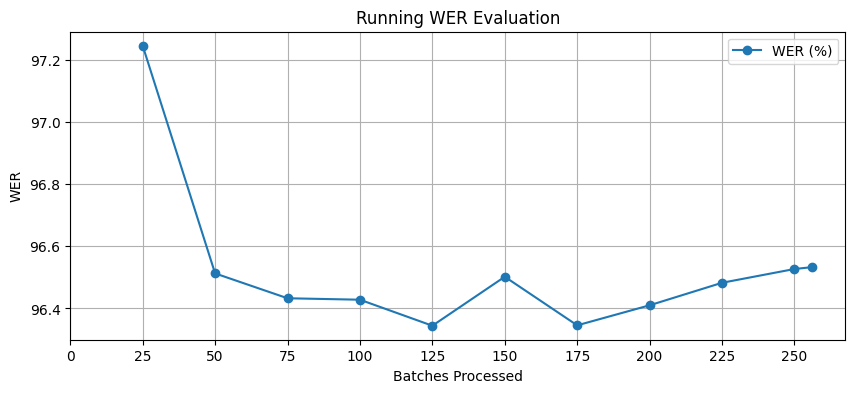

100%|██████████| 256/256 [1:08:14<00:00, 16.00s/it]


96.5329469950542

In [63]:
# Evaluate WER after the training
torch.cuda.empty_cache()
evaluation(trainer.model)

In [ ]:
#----------------------------Load LoRA adaptors from "trained_model" directory and add it to base model to reload---------------------------
from transformers import WhisperForConditionalGeneration
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model
config = LoraConfig(r=32, lora_alpha=64, target_modules=["k_proj", "v_proj", "q_proj", "out_proj"], lora_dropout=0.05, bias="none")

# Load base model
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

loaded_model = get_peft_model(base_model, config)

# Load LoRA adapter
loaded_model = PeftModel.from_pretrained(loaded_model, "lora_trained_model_final")

# ✅ Move model to GPU
loaded_model = loaded_model.to("cuda")



c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
#-----------------------Alternative : Save full model to disk in "merged_full_model" directory---------------------------
# merged_full_model = trainer.model.merge_and_unload()  # merges LoRA into base model
# merged_full_model.save_pretrained("merged_full_model")  # now contains full model weights

#-------------------------------Reload the full model from local "merged_full_model" directory------------------------------------
# from transformers import WhisperForConditionalGeneration
# merged_full_model = WhisperForConditionalGeneration.from_pretrained("merged_full_model")
# # ✅ Move model to GPU
# merged_full_model = merged_full_model.to("cuda")



In [67]:
#-------------------------------Save the loaded model to hugging face------------------------
from transformers import WhisperForConditionalGeneration

# Push to Hugging Face Hub
loaded_model.push_to_hub("imonghose/whisper-small-bengali-lora-final")


adapter_model.safetensors: 100%|██████████| 28.4M/28.4M [00:13<00:00, 2.15MB/s]


CommitInfo(commit_url='https://huggingface.co/imonghose/whisper-small-bengali-lora-final/commit/2000c79a9265f870b71dd92e16a88a5dfa726388', commit_message='Upload model', commit_description='', oid='2000c79a9265f870b71dd92e16a88a5dfa726388', pr_url=None, repo_url=RepoUrl('https://huggingface.co/imonghose/whisper-small-bengali-lora-final', endpoint='https://huggingface.co', repo_type='model', repo_id='imonghose/whisper-small-bengali-lora-final'), pr_revision=None, pr_num=None)

In [23]:
#---------------------------------Reload the model from Hugging Face Hub-----------------------------------
# Load base model
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

peft_model = get_peft_model(base_model, config)
# loaded_model = get_peft_model(loaded_model, "trained_model")

# Load LoRA adapter
final_loaded_model = PeftModel.from_pretrained(peft_model, "imonghose/whisper-small-bengali-lora-final")

# ✅ Move model to GPU
final_loaded_model = final_loaded_model.to("cuda")


c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [69]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using trainer.model)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = trainer.model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : চুলতে পাইনা

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : নিজর সজনে জনল

 
-------9------
True : সে যুদ্ধকেই 
Pred : শে জদ্দ্যে

 


In [70]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from local i.e "trained_model")------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = loaded_model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : চুলতে পাইনা

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : নিজর সজনে জনল

 
-------9------
True : সে যুদ্ধকেই 
Pred : শে জদ্দ্যে

 


In [71]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from hugging face)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = final_loaded_model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : চুলতে পাইনা

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : নিজর সজনে জনল

 
-------9------
True : সে যুদ্ধকেই 
Pred : শে জদ্দ্যে

 


In [24]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from local i.e "trained_model")------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["test"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["test"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = final_loaded_model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : সালাহউদ্দিনের জীবনী লেখার জন্য তিনি খ্যাত। 
Pred : সালাউতিনে জিপনিলাখায় নো তিনিগাত

 
-------8------
True : এই কাগজ কালি ভাল শোষণ করার জন্য রঙ ভালভাবে ফুটে ওঠে। 
Pred : এই কাগছকাই ভালস সনক�াড্য়্ন লক ভাভে প্টে উটে

 
-------9------
True : অনেক ধনী দ্বীপটি কিনতে চেয়েছিলেন। 
Pred : অন্যব ধিনী দেপ্টি যাছেছেন

 
